In [1]:
"""
Hybrid Cuckoo Searchtest function evaluation notebook with example to test user defined function
Requires defined imports, function and utilities python scripts in same path to run. 
""""
import math as mt
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import functions as fn
import utilities as ut
import time
import copy
from numpy import abs, cos, exp, mean, pi, prod, sin, sqrt, sum

In [2]:
def fobj(x):
    """
    Objective functions calculates the value
    :param x: d dimentional input
    :return: A single value
    """
    n = float(x.shape[0])
    firstSum = 0.0
    secondSum = 0.0
    firstSum = np.sum(x ** 2.0) / n
    secondSum = np.sum(np.cos(2.0 * mt.pi * x)) / n
    return -20.0 * mt.exp(-0.2 * mt.sqrt(firstSum / n)) - mt.exp(secondSum / n) + 20 + mt.e


In [3]:
def sort(nests, Ub, Lb, func):
    """
    Function sort the nests based on the fitness of each nest in the list

    :param nests:List of nests
    :param Ub: Upper limit of the limit
    :param Lb: Lower limit
    :param func: Objective function
    :return: Sorted nests with d-dimentional with in limits
    """

    lis = list(nests)
    lis.sort(key=lambda arr: func(arr, Ub, Lb))
    return np.array(lis)

In [4]:
def generate_cuckoos(nest, Ub, Lb, best):
    """
    Function creates more nest around best nest using Levy Flight

    :param nest: list of nests
    :param Ub: Upper limit of objective functions
    :param Lb: Lower limit
    :param best: Current best nest
    :return: List of Nests
    """
    n = nest.shape[0]
    beta = 1.500
    sigma = (mt.gamma(1 + beta) * mt.sin(mt.pi * beta / 2) / (
                mt.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    for j in range(n):
        s = nest[j, :]
        u = np.random.standard_normal(s.shape) * sigma
        v = np.random.standard_normal(s.shape)
        step = u / abs(v) ** (1 / beta)
        stepsize = 0.01 * step * (s - best);
        s = s + stepsize * np.random.standard_normal(s.shape)
        #       print(s)
        nest[j, :] = ut.simplebounds(s, Ub, Lb)
    return nest

In [5]:
def delete_worst(nest, pa, Ub, Lb):
    """
    Function deletes pa percentage of nests according to fitness values

    :param nest: List of nests
    :param pa: Percentage of nests need to be deleted
    :param Ub: Upper limit
    :param Lb: lower Limit
    :return: List of nests
    """

    #   print(nests)
    n = nest.shape[0]
    # print(n)
    k = np.random.standard_normal(nest.shape) > pa
    stepsize = rd.random() * (nest[np.random.permutation(n), :] - nest[np.random.permutation(n), :])
    new_nest = nest + stepsize * k
    for j in range(n):
        s = new_nest[j, :]
        #       print("delete_worst")
        #       print(s)
        new_nest[j, :] = ut.simplebounds(s, Ub, Lb)
        # print(new_nest.shape)
    return new_nest

In [6]:
def monte_carlo(nests, Ub, Lb):
    """
    Performs normal monte carlo Local expoloration around nests

    :param nests:List of nests
    :param Ub:Upper limit of exploration space
    :param Lb:Lower limit of explaration space
    :return:list of nests
    """

    n = nests.shape[0]
    stepsize = rd.random() * (nests[np.random.permutation(n), :] - nests[np.random.permutation(n), :])
    for index, nest in enumerate(nests):
        tempfobj = fn.michalewicz(nest, Ub, Lb)
        for steps in range(10):
            s = nests[index, :]
            #   u=np.random.standard_normal(s.shape)
            #   k = np.random.standard_normal(nest.shape)
            k = np.random.standard_normal(nest.shape) > pa

            newnest = nest + k * stepsize[index]
            newnest = ut.simplebounds(newnest, Ub, Lb)
            fobjnew = fn.michalewicz(newnest, Ub, Lb)
            if fobjnew < tempfobj:
                nests[index] = newnest
    return nests

In [7]:
def monte_carlo_hastings(nests, Ub, Lb, max_iter, func, topnests):
    """
    Function performs local search using monte-carlo

    :param nests:List of nests
    :param Ub:Upper limit of exploration space
    :param Lb:Lower limit of explaration space
    :param max_iter:Maximum iterations
    :param func:Objective function
    :param topnests:topnests
    :return: list of nests
    """

    i = 0
    num_nests = nests.shape[0]
    stepsize = 0.02
    perc = 0.25
    nests = sort(nests, Ub, Lb, func)
    bestnests = int(topnests * num_nests)
    keepnests = nests[0:bestnests, :]
    n_dim = nests.shape[1]
    n_dim_per_iter = max(1, int(perc * n_dim))
    models = np.zeros([max_iter, n_dim])
    energy = np.zeros(max_iter)

    stepsize = np.full(n_dim, stepsize)
    for index, nest in enumerate(keepnests):
        models = np.zeros([max_iter, n_dim])
        energy = np.zeros(max_iter)
        stepsize = np.full(n_dim, stepsize)
        models[0, :] = nests[index]
        energy[0] = func(models[0, :], Ub, Lb)
        i = 0
        rejections = 0
        acceptance = 0
        sigma = 1.0
        while i < max_iter - 1:

            for j in np.arange(0, n_dim, n_dim_per_iter):
                i += 1
                jmax = min(n_dim, j + n_dim_per_iter - 1)
                models[i, :] = models[i - 1, :]
                randn_step = sigma * np.random.randn(jmax - j + 1)
                models[i, j:jmax + 1] += randn_step * stepsize[j:jmax + 1]
                models[i, :] = ut.simplebounds(models[i, :], Ub, Lb)
                energy[i] = func(models[i, :], Ub, Lb)
                log_alpha = min(0., energy[i - 1] - energy[i])
                if energy[i - 1] > energy[i]:
                    acceptance += acceptance
                if energy[i - 1] <= energy[i]:
                    models[i, :] = models[i - 1, :]
                    energy[i] = energy[i - 1]
                    rejections += 1
                if (rejections > 0.4 * (max_iter - 1)):
                    sigma = sigma / 1.5
                if (acceptance > 0.3 * (max_iter - 1)):
                    sigma = sigma * 1.5

                # =============================================================================
                #                 if log_alpha < np.log(np.random.rand()):
                #                     rejected += 1
                #                     models[i,:] = models[i-1,:]
                #                     energy[i] = energy[i-1]
                # =============================================================================

                if i == max_iter - 1:
                    break
        idx = np.argmin(energy)
        nests[index, :] = models[idx, :]
    nests = sort(nests, Ub, Lb, func)
    nests[bestnests:-1, :] = delete_worst(nests[bestnests:-1, :], 0.5, Ub, Lb)
    return nests

In [8]:
def get_best(nests, new_nests, Ub, Lb, func):
    """
    Returns the best nest from the list of nests
    """
    fmin = 10000000.0
    best = 0
    for index, nest in enumerate(new_nests):
        fitness_new = func(nest, Ub, Lb)
        # print(fitness_new)
        fitness_old = func(nests[index], Ub, Lb)
        # print(fitness_old)
        if fitness_new < fitness_old:
            nests[index, :] = nest
            if fitness_new < fmin:
                fmin = fitness_new
                best = index
        if fitness_old < fmin:
            fmin = fitness_old
            best = index
    return nests[best, :], fmin, nests

In [9]:
def cuckoo_search(num_nests, ndim, num_iters, Ulim, Llim, funcs):
    """
    Base line cuckoo Search using Levy Flight
    https://ieeexplore.ieee.org/document/5393690/citations?tabFilter=patents#anchor-patent-citations

    """
    _perIter = 4 * num_nests
    cuckoo_values = []
    temp_values = []
    index = 0
    for index, (func, iters) in enumerate(zip(funcs, num_iters)):
        Lb = Llim[index] * np.ones([1, ndim[index]])
        Ub = Ulim[index] * np.ones([1, ndim[index]])
        nests = np.tile(Lb, (num_nests, 1)) + np.tile(Ub - Lb, (num_nests, 1)) * np.random.rand(num_nests, ndim[index])
        nests = ut.standardize(nests, Ub, Lb)
        new_nests = nests
        bestnest, fmin, nests = get_best(nests, new_nests, Ub, Lb, func)
        for _ in range(num_iters[index]):
            new_nests = generate_cuckoos(nests, Ub, Lb, bestnest)
            best, fnew, nests = get_best(nests, new_nests, Ub, Lb, func)
            new_nests = delete_worst(nests, 0.7, Ub, Lb)
            best, fnew, nests = get_best(nests, new_nests, Ub, Lb, func)
            if fnew < fmin:
                fmin = copy.copy(fnew)
                bestnest = best
            temp_values.append(fmin)
            # arr = np.array(computats)
            # temp_values.append(fmin)
            # plt.plot(arr[:, 1], arr[:,0])
        # favg = np.mean(temp_values)
        cuckoo_values.append(temp_values)
        temp_values = []
        # index += 1
    return cuckoo_values

In [10]:
def hybrid_search(num_nests, ndim, num_iters, Ulim, Llim, funcs, relerror):
    """
    Hybrid cuckoo Search with an addition Monte Carlo Hasting for local exploration

    """
    local_iter = 20
    # topnests = [0.1, 0.2, 0.3, 0.4, 0.5]
    # _perIter = 4*num_nests + local_iter*4
    final_result = {}
    # for topnest in topnests:
    func_mean = []
    func_std = []
    index = 0
    topnest = 0.3
    final_result = {}
    cuckoo_values = []
    for index, func in enumerate(funcs):
        computats = []
        Lb = Llim[index] * np.ones([1, ndim[index]])
        Ub = Ulim[index] * np.ones([1, ndim[index]])
        temp_values = []
        #        for _ in range(10):
        nests = np.tile(Lb, (num_nests, 1)) + np.tile(Ub - Lb, (num_nests, 1)) * np.random.rand(num_nests, ndim[index])
        nests = ut.standardize(nests, Ub, Lb)
        # print(nests)
        new_nests = nests
        bestnest, fmin, nests = get_best(nests, new_nests, Ub, Lb, func)
        fobj_comps = 0
        for i in range(num_iters[index]):
            # while abs(fmin) > abs(relerror[index]):
            new_nests = generate_cuckoos(nests, Ub, Lb, bestnest)
            best, fnew, nests = get_best(nests, new_nests, Ub, Lb, func)
            new_nests = monte_carlo_hastings(nests, Ub, Lb, local_iter, func, topnest)
            best, fnew, nests = get_best(nests, new_nests, Ub, Lb, func)
            new_nests = delete_worst(nests, 0.5, Ub, Lb)
            best, fnew, nests = get_best(nests, new_nests, Ub, Lb, func)
            if fnew < fmin:
                fmin = copy.copy(fnew)
                bestnest = best
            # fobj_comps += local_iter*topnest*num_nests + num_nests*4
            # computats.append(fobj_comps)
            # arr = np.array(computats)
            temp_values.append(fmin)
        # print(i)
        #  print(temp_values)
        #           print(temp_values)
        # plt.plot(arr[:, 1], arr[:,0])
        # favg = np.mean(temp_values)
        # func_mean.append(np.mean(computats))
        # func_std.append(np.std(computats))
        cuckoo_values.append(temp_values)
        # index += 1
    # final_result = [func_mean, func_std, cuckoo_values]
    #   print(cuckoo_values)
    return cuckoo_values

In [11]:
def test_function_template( x, Ub, Lb, a=20, b=0.2, c=2*mt.pi ):
    """"
    Template to define a new function
    """
    x = ut.standardize(x, Ub, Lb)
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    n = len(x)
    s1 = sum( x**2 )
    s2 = sum( cos( c * x ))
    return -a*exp( -b*sqrt( s1 / n )) - exp( s2 / n ) + a + exp(1)

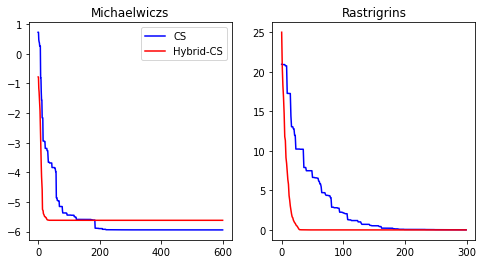

In [20]:
if __name__ == "__main__":

    rd.seed(a=3000)

    funcs = [fn.michalewicz, fn.rastrigin]
    num_iters = [600, 300]
    Llim = [0, -5]
    Ulim = [mt.pi, 5]
    ndim = [10, 16]

    pa = 0.65
    fobj_comps = 0
    num_nests = 15

    fvalues = cuckoo_search(num_nests, ndim, num_iters, Ulim, Llim, funcs)

    fvalues_hybrid = hybrid_search(num_nests, ndim, num_iters, Ulim, Llim, funcs, fvalues)

    figure, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(range(num_iters[0]), fvalues[0], color='b', label = 'CS')
    ax[0].plot(range(num_iters[0]), fvalues_hybrid[0], color='r', label = 'Hybrid-CS')
    ax[1].plot(range(num_iters[1]), fvalues[1], color='b')
    ax[1].plot(range(num_iters[1]), fvalues_hybrid[1], color='r')
    ax[0].set_title('Michaelwiczs')
    ax[1].set_title('Rastrigrins')
    ax[0].legend()

    plt.savefig('Figure3.png')

In [13]:
#####   Exampple to add a new function ####
###    Uncomment the lines to run a new function

    # rd.seed(a=3000)
    #
    # funcs = [test_function_template]
    # num_iters = [300]
    # Llim = [0]
    # Ulim = [mt.pi]
    # ndim = [10]
    #
    # pa = 0.65
    # fobj_comps = 0
    # num_nests = 15
    #
    # fvalues = cuckoo_search(num_nests, ndim, num_iters, Ulim, Llim, funcs)
    #
    # fvalues_hybrid = hybrid_search(num_nests, ndim, num_iters, Ulim, Llim, funcs, fvalues)
    #
    # #figure, ax = plt.subplots(1, 2, figsize=(8, 4))
    # plt.plot(range(num_iters[0]), fvalues[0], color='b', label='CS')
    # plt.plot(range(num_iters[0]), fvalues_hybrid[0], color='r', label='Hybrid-CS')
    # plt.title('New Function')
    # plt.legend()
    #
    # plt.savefig('Test_Figure1.png')